In [2]:
import pickle
import requests
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## The Question

As a lifelong Jay-Z fan, I've observed the content of his music change dramatically over time from his gritty humble beginnings in Brooklyn's Marcy Projects and hustling in Trenton, NJ, to the trend-setting billionaire mogul we know today. I wondered if Natural Language Processing & Machine Learning techniques (specifically clustering) could be used to demonstrate these changes and perhaps draw further insights.

In addition to answering the question above, I knew this exercise would give me the opportunity to play around with web scraping, working with APIs, NLP, Unsupervised Learning, and tying all of the above together cohesively.

## The Process

Answering my question would be a process conducted in several steps:

    1. Grab the lyrics for all relevant Jay-Z songs
    2. Preprocess data in a manner that lends itself to easy comparison between songs
    3. Analyze data and draw conclusions.

I had previously interacted with the Lyrics.OVH API for a previous exercise, so I knew it would be useful for retreiving song lyrics. However because this API provides the lyrics for a single song given the title, I would need to provide all relevant song titles. Rather than do this manually, I decided to employ web scraping on his Wikipedia page. From his main Wikipedia page, I could retrieve the album titles, and links to each of the album pages, and then from each album page, I could retrieve the titles of every song on the album, which I could then feed to Lyrics.OVH to retrieve the lyrics.

For the preprocessing step to make comparison of songs feasible, I decided to use count vectorization, a simple method where we turn each song into a vector that counts the number of times each word appearing in any of the songs in our analysis appears in that particular song. Essentially, it gives us a numeric representation which machine learning algorithms are much better at dealing with than pure words.

Once the count vectors are established for each song, perhaps we can use clustering algorithms on those vectors to see what the optimal number of song clusters is, and what the songs in each cluster have in common with each other.

With all that in mind, let's go!

## Get all lyrics through web scraping

Starting from the url for Jay-Z's Wikipedia page, we can use the BeautifulSoup package to identify the links to each one of his album pages, then extract all of the song titles from each album and append them to a master list of songs.

Note that only songs appearing on his studio albums were considered for this analysis.

In [3]:
url = 'https://en.wikipedia.org/wiki/Jay-Z'

html_page = requests.get(url)
soup = BeautifulSoup(html_page.content, 'html.parser')
album_container = soup.find('dl').nextSibling.nextSibling

In [4]:
album_container

<div class="div-col columns column-width" style="-moz-column-width: 30em; -webkit-column-width: 30em; column-width: 30em;">
<ul><li><i><a href="/wiki/Reasonable_Doubt_(album)" title="Reasonable Doubt (album)">Reasonable Doubt</a></i> (1996)</li>
<li><i><a href="/wiki/In_My_Lifetime,_Vol._1" title="In My Lifetime, Vol. 1">In My Lifetime, Vol. 1</a></i> (1997)</li>
<li><i><a href="/wiki/Vol._2..._Hard_Knock_Life" title="Vol. 2... Hard Knock Life">Vol. 2... Hard Knock Life</a></i> (1998)</li>
<li><i><a href="/wiki/Vol._3..._Life_and_Times_of_S._Carter" title="Vol. 3... Life and Times of S. Carter">Vol. 3... Life and Times of S. Carter</a></i> (1999)</li>
<li><i><a href="/wiki/The_Dynasty:_Roc_La_Familia" title="The Dynasty: Roc La Familia">The Dynasty: Roc La Familia</a></i> (2000)</li>
<li><i><a href="/wiki/The_Blueprint" title="The Blueprint">The Blueprint</a></i> (2001)</li>
<li><i><a href="/wiki/The_Blueprint_2:_The_Gift_%26_The_Curse" title="The Blueprint 2: The Gift &amp; The Curse"

In [5]:
song_links = album_container.find_all('a')

In [6]:
song_links

[<a href="/wiki/Reasonable_Doubt_(album)" title="Reasonable Doubt (album)">Reasonable Doubt</a>,
 <a href="/wiki/In_My_Lifetime,_Vol._1" title="In My Lifetime, Vol. 1">In My Lifetime, Vol. 1</a>,
 <a href="/wiki/Vol._2..._Hard_Knock_Life" title="Vol. 2... Hard Knock Life">Vol. 2... Hard Knock Life</a>,
 <a href="/wiki/Vol._3..._Life_and_Times_of_S._Carter" title="Vol. 3... Life and Times of S. Carter">Vol. 3... Life and Times of S. Carter</a>,
 <a href="/wiki/The_Dynasty:_Roc_La_Familia" title="The Dynasty: Roc La Familia">The Dynasty: Roc La Familia</a>,
 <a href="/wiki/The_Blueprint" title="The Blueprint">The Blueprint</a>,
 <a href="/wiki/The_Blueprint_2:_The_Gift_%26_The_Curse" title="The Blueprint 2: The Gift &amp; The Curse">The Blueprint<sup>2</sup>: The Gift &amp; the Curse</a>,
 <a href="/wiki/The_Black_Album_(Jay-Z_album)" title="The Black Album (Jay-Z album)">The Black Album</a>,
 <a href="/wiki/Kingdom_Come_(Jay-Z_album)" title="Kingdom Come (Jay-Z album)">Kingdom Come</a>,

In [7]:
# url2 = f'https://en.wikipedia.org{ song_links[0].attrs["href"] }'

album_urls = [ f'https://en.wikipedia.org{ s.attrs["href"] }' for s in song_links ]
album_urls

['https://en.wikipedia.org/wiki/Reasonable_Doubt_(album)',
 'https://en.wikipedia.org/wiki/In_My_Lifetime,_Vol._1',
 'https://en.wikipedia.org/wiki/Vol._2..._Hard_Knock_Life',
 'https://en.wikipedia.org/wiki/Vol._3..._Life_and_Times_of_S._Carter',
 'https://en.wikipedia.org/wiki/The_Dynasty:_Roc_La_Familia',
 'https://en.wikipedia.org/wiki/The_Blueprint',
 'https://en.wikipedia.org/wiki/The_Blueprint_2:_The_Gift_%26_The_Curse',
 'https://en.wikipedia.org/wiki/The_Black_Album_(Jay-Z_album)',
 'https://en.wikipedia.org/wiki/Kingdom_Come_(Jay-Z_album)',
 'https://en.wikipedia.org/wiki/American_Gangster_(album)',
 'https://en.wikipedia.org/wiki/The_Blueprint_3',
 'https://en.wikipedia.org/wiki/Magna_Carta_Holy_Grail',
 'https://en.wikipedia.org/wiki/4:44']

In [8]:
def get_song_titles(url):
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')

    tracklist = soup.find('table', class_='tracklist')
    trs = tracklist.find_all('tr')[1:]

    songs = []

    for tr in trs:
        tds = tr.find_all('td')
        if len(tds) > 1:
            title_raw = tds[1].text
            title_list = title_raw.split('"')
            
            if len(title_list) > 1: 
                songs.append(title_list[1])
            
    return songs

In [9]:
def get_lyrics(artist, title):
    url = f'https://api.lyrics.ovh/v1/{ artist }/{ title }'
    
    response = requests.get(url)
    
    if response.status_code == 200: return response.json()['lyrics']
        
    return ''

In [10]:
songs = []

for a in album_urls: 
    songs.extend(get_song_titles(a))
    
songs

["Can't Knock the Hustle",
 'Politics as Usual',
 "Brooklyn's Finest",
 'Dead Presidents II',
 "Feelin' It",
 "D'Evils",
 "22 Two's",
 'Can I Live',
 "Ain't No Nigga",
 'Friend or Foe',
 'Coming of Age',
 'Cashmere Thoughts',
 'Bring It On',
 'Regrets',
 'Intro / A Million And One Questions / Rhyme No More',
 'The City Is Mine',
 'I Know What Girls Like',
 'Imaginary Player',
 'Streets Is Watching',
 "Friend or Foe '98",
 'Lucky Me',
 '(Always Be My) Sunshine',
 'Who You Wit II',
 'Face Off',
 'Real Niggaz',
 'Rap Game / Crack Game',
 "Where I'm From",
 'You Must Love Me',
 'Intro – Hand It Down',
 'Hard Knock Life (Ghetto Anthem)',
 'If I Should Die',
 'Ride or Die',
 'Nigga What, Nigga Who (Originator 99)',
 'Money, Cash, Hoes',
 'A Week Ago',
 'Coming of Age (Da Sequel)',
 'Can I Get A...',
 'Paper Chase',
 'Reservoir Dogs',
 "It's Like That",
 'Hova Song (Intro)',
 'So Ghetto',
 'Do It Again (Put Ya Hands Up)',
 'Dope Man',
 'Things That U Do',
 "It's Hot (Some Like It Hot)",
 'Sno

In [11]:
song_dict = {}

In [13]:
for s in songs:
    lyrics = get_lyrics('Jay-Z', s)
    
    song_dict[s] = lyrics
    
    print(s, '\n-----\n')
    print(lyrics, '\n\n')

In [152]:
pickle.dump( song_dict, open( "save.song_dict", "wb" ) )

In [14]:
song_dict = pickle.load( open( "save.song_dict", "rb" ) )

In [15]:
song_snippets = list(zip(song_dict.keys(), map(lambda x: song_dict[x][:90], song_dict)))

for i, s in enumerate(song_snippets): print(i, s)

0 ("Can't Knock the Hustle", "I'm makin' sure it turns gold, when the weather folds,\nJust put away the leathers and put ")
1 ('Politics as Usual', 'You know how we do, Roc-a-Fella... forever... You can catch me\nSkatin through your town pu')
2 ("Brooklyn's Finest", "(feat. Notorious B.I.G.)\r\n[Pain In Da Ass] \n\n[*gunshots*] OKAY, I'M RELOADED!!! \nYou mothe")
3 ('Dead Presidents II', '"Presidents to represent me" --> Nas "Get money!"\n"I\'m out for presidents to represent me"')
4 ("Feelin' It", "[Chorus:]\r\nI'm feelin it fill the glass to the top with Moet\r\nFeelin it feel the Lex pushi")
5 ("D'Evils", "This shit is wicked on these mean streets\r\nNone of my friends speak\r\nWe're all trying to w")
6 ("22 Two's", "[People clapping]\r\nYo whassup everybody this is Mariah Davis, Mad Wednesday's\r\nwe here ton")
7 ('Can I Live', "Yeah, (hah, yeah) Roc-A-Fella\nWe invite you to, somethin' epic y'all know?(something, some")
8 ("Ain't No Nigga", 'I keep you fresher than the next bitch,

We did it! 171 songs complete with titles & all lyrics.

Looking at all songs sorted by length from smallest to largest allowed me to identify any songs that may not have been retrieved properly and deal with those issues.

In [16]:
song_lengths = list(zip(song_dict.keys(), map(lambda x: len(song_dict[x]), song_dict)))
sorted(song_lengths, key=lambda x: x[1])

[('Interlude', 14),
 ('Cashmere Thoughts', 90),
 ('The City Is Mine', 173),
 ('Versus', 353),
 ('Beach Is Better', 635),
 ('BBC', 1387),
 ('Friend or Foe', 1529),
 ('La Familia', 1530),
 ("Friend or Foe '98", 1641),
 ('Moonlight', 1743),
 ('Intro', 1769),
 ('Crown', 1775),
 ('Kill Jay Z', 1784),
 ('Holla', 1786),
 ('Tom Ford', 1796),
 ('Heaven', 1837),
 ('Venus vs. Mars', 1864),
 ('Fuckwithmeyouknowigotit', 1984),
 ('Hate', 2050),
 ('Hova Song (Intro)', 2052),
 ('Hova Song (Outro)', 2052),
 ('Legacy', 2072),
 ('American Gangster', 2078),
 ('Marcy Me', 2080),
 ('The Prelude', 2124),
 ('Intro - Hand It Down', 2154),
 ('Politics as Usual', 2223),
 ('No Hook', 2234),
 ('Blueprint (Momma Loves Me)', 2243),
 ('Pray', 2258),
 ('So Ambitious', 2343),
 ('I Made It', 2349),
 ('Picasso Baby', 2353),
 ('Sweet', 2368),
 ('D.O.A. (Death of Auto-Tune)', 2375),
 ('Minority Report', 2423),
 ('Oh My God', 2435),
 ('Nickels and Dimes', 2449),
 ('4:44', 2458),
 ('What They Gonna Do', 2491),
 ('F.U.T.W.', 

In [18]:
# Missing Songs - we were unable to retrieve these songs via the lyrics.ovh API (0 length)
# Most of these are just not present in the database. A couple have slight misspellings we can correct

# [('Intro / A Million And One Questions / Rhyme No More', 0),
#  ('Rap Game / Crack Game', 0),
#  ('Intro – Hand It Down', 0),
#  ("Heart of the City (Ain't No Love)", 0),
#  ('Somewhereinamerica', 0),
#  ('Part II (On the Run)', 0),
#  ('JAY Z Blue', 0),
#  ('The Story of O.J.', 0) ]

missing_songs = [
    'Intro / A Million And One Questions / Rhyme No More',
    'Rap Game / Crack Game',
    'Intro – Hand It Down',
    "Heart of the City (Ain't No Love)",
    'Somewhereinamerica',
    'Part II (On the Run)',
    'JAY Z Blue',
    'The Story of O.J.' 
]

replacement_songs = [ 
    'Intro - Hand It Down', # Wrong character used for dash. Needed "-" instead of "–". Crazy, I know...
    'Part II (On The Run)', # T in "The" needed to be capitalized
]



It turns out that 10 of 179 songs were missing overall. Not too bad. Of those, 2 were due to slight misspellings. Once those were corrected, I was able to retrieve them and add to our dataset. The other 8 songs were simply not present on Lyrics.OVH, so I removed the titles from our list and continued. Another possibility would be to track them down using another API or dataset, however for our purposes here, 171 of 179 songs seems fine.

In [20]:
# for s in missing_songs: del song_dict[s]

In [153]:
for s in replacement_songs:
    lyrics = get_lyrics('Jay-Z', s)
    song_dict[s] = lyrics
    
    print(s, '\n-----\n')
    print(lyrics, '\n\n')

In [154]:
# for s in song_dict: print(s)

In [181]:
word_tokenizer = RegexpTokenizer(r'\w+')

wordlist = list(map(lambda x: word_tokenizer.tokenize((x + '. ' + song_dict[x]).lower()), song_dict))
wordlist = list(map(lambda x: ' '.join(x), wordlist))

In [194]:
# instantiate our CountVectorizer. This counts the number of appearances of all the words in our training data and
# eliminates common english stop words. 5000 max features works well for our purposes (tested various numbers). Our
# data is already preprocessed and tokenized manually earlier. ngram_range is 1,3, although all or nearly all our 
# features are single words

vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = 'english',
                             max_features = 5000,
                             ngram_range = (1, 3))

In [195]:
# fit our training data and test data lists to our count_vectorizer

word_features = vectorizer.fit_transform(wordlist)

# convert to array

word_features = word_features.toarray()

In [196]:
# check shapes

word_features.shape # , test_data_features.shape

(172, 5000)

In [270]:
# I wanted check that the features corpus was as expected - removed print statement for readability

vocab = vectorizer.get_feature_names()
# np.random.choice(vocab, 200)

In [217]:
display(len(album_urls), album_urls)

13

['https://en.wikipedia.org/wiki/Reasonable_Doubt_(album)',
 'https://en.wikipedia.org/wiki/In_My_Lifetime,_Vol._1',
 'https://en.wikipedia.org/wiki/Vol._2..._Hard_Knock_Life',
 'https://en.wikipedia.org/wiki/Vol._3..._Life_and_Times_of_S._Carter',
 'https://en.wikipedia.org/wiki/The_Dynasty:_Roc_La_Familia',
 'https://en.wikipedia.org/wiki/The_Blueprint',
 'https://en.wikipedia.org/wiki/The_Blueprint_2:_The_Gift_%26_The_Curse',
 'https://en.wikipedia.org/wiki/The_Black_Album_(Jay-Z_album)',
 'https://en.wikipedia.org/wiki/Kingdom_Come_(Jay-Z_album)',
 'https://en.wikipedia.org/wiki/American_Gangster_(album)',
 'https://en.wikipedia.org/wiki/The_Blueprint_3',
 'https://en.wikipedia.org/wiki/Magna_Carta_Holy_Grail',
 'https://en.wikipedia.org/wiki/4:44_(album)']

In [265]:
from wordcloud import WordCloud, STOPWORDS

In [272]:
local_stopwords = ['fuck', 'shit', 'bitch', 'nigga', 'niggas', 'niggaz', 'fuckin']

In [283]:
def wordcloud(wordstring, stopwords=False, figsize=(20,20)):
    sw = set(STOPWORDS)
    sw.update(local_stopwords)
    
    if stopwords: sw.update(stopwords)
    
    # Create and generate a word cloud image:
    wordcloud = WordCloud(stopwords=sw, background_color='white').generate(wordstring)
    
    # Display the generated image:
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='gaussian')
    plt.axis('off')
    plt.show()

In [284]:
wordlist_smushed = ' '.join(wordlist)

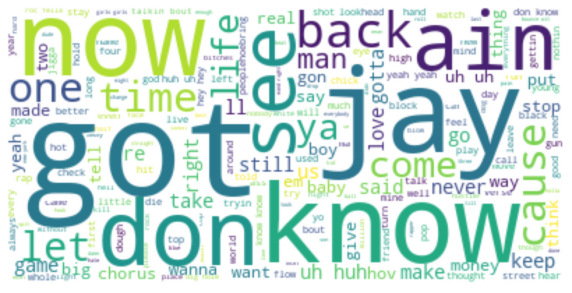

In [291]:
wordcloud(wordlist_smushed, figsize=(10,10))

In [240]:
# Clustering

from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score

num_clusters = np.arange(2, 20)
chz_scores = []
sil_scores = []

# Set number of clusters at initialization time
for n in num_clusters:
    k_means = KMeans(n_clusters=n) 

    # Run the clustering algorithm
    k_means.fit(word_features) 

    # Generate cluster index values for each row
    cluster_assignments = k_means.predict(word_features)
    
    chz_score = calinski_harabasz_score(word_features, cluster_assignments)
    sil_score = silhouette_score(word_features, cluster_assignments)
    
    chz_scores.append(chz_score)
    sil_scores.append(sil_score)
    
    print(n, chz_score, sil_score)
    

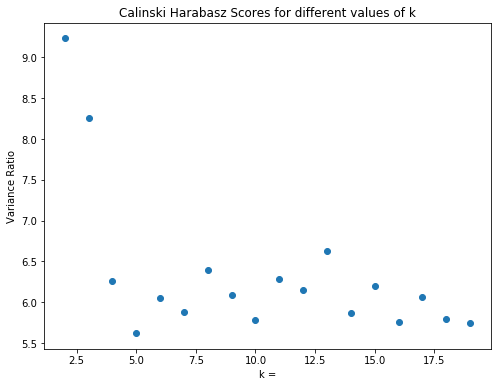

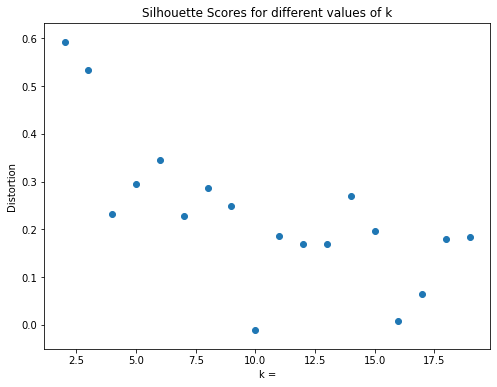

In [246]:
f, ax = plt.subplots(figsize=(8,6))
plt.scatter(num_clusters, chz_scores)
plt.title('Calinski Harabasz Scores for different values of k')
plt.xlabel('k =')
plt.ylabel('Variance Ratio');

f, ax = plt.subplots(figsize=(8,6))
plt.scatter(num_clusters, sil_scores)
plt.title('Silhouette Scores for different values of k')
plt.xlabel('k =')
plt.ylabel('Distortion');

In [ ]:
len(num_clusters), len(chz_scores)

In [292]:
cluster_assignments

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0,  2,
        2,  2,  2,  2,  2,  6,  2,  2,  2,  2, 18,  2,  2,  2,  2,  2,  7,
        2,  1,  2,  2,  2,  2,  2, 13,  2,  2,  2, 12,  5,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  1,  2, 16,  2,  2,  2,  2,  2,  2,  2,  2,  9,  2,  2,  2,  2,
        2,  2,  2, 17,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 10,  2,  2,
        2,  2,  0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  8,  2,  2,
        2,  2,  2,  2,  2,  2,  4,  2,  2, 14,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  3,  2,  2,  2,  2,  2, 15,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 11,  2,  2,  2,  2,
        2,  2], dtype=int32)

In [299]:
url2 = 'https://en.wikipedia.org/wiki/Rihanna'

html_page = requests.get(url2)
soup = BeautifulSoup(html_page.content, 'html.parser')
album_container = soup.find('dl').nextSibling.nextSibling
album_container

In [300]:
album_container

In [301]:
song_links = album_container.find_all('a')

AttributeError: 'NoneType' object has no attribute 'find_all'